## SetUp

#### Library env == TaeYoung

In [1]:
import pandas as pd
import numpy as np

# PreProcessing
from sklearn.preprocessing import MinMaxScaler

# Scoring
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist

# Clustering
from sklearn.cluster import KMeans

#### Libray env == test

In [3]:
# 라이브러리
import geopandas as gpd # 0.14.4
import matplotlib.pyplot as plt
import fiona # 1.10
from shapely.ops import unary_union
from shapely.geometry import box
import os
from pyproj import Transformer

#### config

In [4]:
dir = "/Users/kangtaeyoung/Desktop/working/apstat_kartell"
os.chdir(dir)

## Area : env == test

In [5]:
base = gpd.read_file("/Users/kangtaeyoung/Desktop/working/apstat_kartell/data/geo/geo_data.shp", encoding = "utf-8") 
base.head(3)

,BASE_DATE,ADM_NM,ADM_CD,geometry
0,20230701,사직동,11010530,"MULTIPOLYGON (((953869.795 1952342.790, 953867..."
1,20230701,부암동,11010550,"MULTIPOLYGON (((951754.343 1956228.708, 951763..."
2,20230701,평창동,11010560,"MULTIPOLYGON (((953994.102 1958989.592, 954025..."


In [6]:
base = base.to_crs("EPSG:5186")

In [7]:
gyeonggi_only = base[base['ADM_CD'].astype(str).str.startswith('31')]

# 결과 출력
print(gyeonggi_only)

     BASE_DATE ADM_NM    ADM_CD  \
105   20230701    대야동  31160630   
106   20230701    송부동  31160640   
153   20230701   동탄7동  31240691   
240   20230701    대월면  31210350   
241   20230701    모가면  31210360   
...        ...    ...       ...   
3132  20230701   산본1동  31160540   
3133  20230701   산본2동  31160550   
3179  20230701   운정6동  31200516   
3180  20230701   운정5동  31200515   
3183  20230701    원문동  31110522   

                                               geometry  
105   MULTIPOLYGON (((192260.013 524041.438, 192252....  
106   MULTIPOLYGON (((195400.069 525494.348, 195400....  
153   MULTIPOLYGON (((211773.418 507694.949, 211769....  
240   MULTIPOLYGON (((246653.814 514324.096, 246658....  
241   MULTIPOLYGON (((239124.574 505577.706, 239086....  
...                                                 ...  
3132  MULTIPOLYGON (((194739.174 531036.430, 194740....  
3133  MULTIPOLYGON (((194069.489 530879.582, 194110....  
3179  MULTIPOLYGON (((176291.754 568050.920, 176281....  

In [8]:
gyeonggi_only['area'] = gyeonggi_only.geometry.area

/opt/anaconda3/envs/test/lib/python3.13/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [9]:
geo_scale = gyeonggi_only[gyeonggi_only["area"] >= 500000]

In [10]:
# 각 지형 도형의 중심 좌표 구하기
geo_scale['centroid'] = geo_scale.geometry.centroid

/opt/anaconda3/envs/test/lib/python3.13/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [11]:
len(geo_scale)

98

In [ ]:
# 면적 계산 (제곱미터 단위로 결과 저장)
gyeonggi_only['area'] = gyeonggi_only.geometry.area

# 결과 출력
gyeonggi_only.to_csv("area.csv")

## Data : env == TaeYoung

In [222]:
temp = pd.read_csv("/Users/kangtaeyoung/Desktop/working/apstat_kartell/data/data98.csv", encoding="cp949")
score = temp.copy()

temp = pd.read_csv("./data/area.csv")
area = temp.copy()

In [223]:
score.head(3)

,시도,ADM_NM,인구밀도,면적(km2),접근성 점수,하수처리장
0,경기도 고양시,가좌동,1428.0,13.63,420336.8890,0
1,경기도 가평군,가평읍,136.0,144.86,789091.9350,3
2,경기도 평택시,고덕면,615.0,22.18,710903.7965,3


In [224]:
area[area["ADM_NM"] == "고촌읍"]

,Unnamed: 0,BASE_DATE,ADM_NM,ADM_CD,geometry,area
448,3084,20230701,고촌읍,31230120,MULTIPOLYGON (((178194.52071252983 559224.0800...,770018.482459


In [225]:
area = area[["ADM_NM", "area"]]
result = pd.merge(score, area, on='ADM_NM', how='left')
result = result.drop(columns="면적(km2)")
result.rename(columns={"area" : "면적"}, inplace=True)
result.head(3)

,시도,ADM_NM,인구밀도,접근성 점수,하수처리장,면적
0,경기도 고양시,가좌동,1428.0,420336.8890,0,1.178035e+07
1,경기도 가평군,가평읍,136.0,789091.9350,3,1.027246e+08
2,경기도 평택시,고덕면,615.0,710903.7965,3,2.042752e+07


In [226]:
# area 열을 km^2로 변환
result['면적'] = result['면적'] / 1_000_000

# 방향 바꾸기
result["인구밀도"] = 1 / result["인구밀도"]
result["접근성 점수"] = 1 / result["접근성 점수"]
score = result.copy()

In [227]:
score["위치"] = score["시도"] + score["ADM_NM"]
score.drop(columns=["ADM_NM", "시도"], inplace=True)
score.set_index("위치", inplace=True)
score.head(3)

,인구밀도,접근성 점수,하수처리장,면적
위치,,,,
경기도 고양시가좌동,0.000700,0.000002,0,11.780347
경기도 가평군가평읍,0.007353,0.000001,3,102.724607
경기도 평택시고덕면,0.001626,0.000001,3,20.427519


In [228]:
score.isnull().sum()

인구밀도      0
접근성 점수    0
하수처리장     0
면적        0
dtype: int64

## Score

In [229]:
temp = score._get_numeric_data()

scaler = MinMaxScaler()
score = pd.DataFrame(scaler.fit_transform(temp), columns=score.columns.to_list(), index=score.index.to_list())
score

,인구밀도,접근성 점수,하수처리장,면적
경기도 고양시가좌동,0.001411,0.590023,0.000000,0.054079
경기도 가평군가평읍,0.016249,0.104827,0.272727,0.499626
경기도 평택시고덕면,0.003476,0.165656,0.272727,0.096442
경기도 고양시고봉동,0.002199,0.778406,0.000000,0.109338
경기도 안성시고삼면,0.030402,0.110220,0.090909,0.113603
...,...,...,...,...
경기도 고양시풍산동,0.000182,0.768580,0.000000,0.004558
경기도 김포시하성면,0.012892,0.413066,0.181818,0.259776
경기도 화성시향남읍,0.001017,0.271613,0.181818,0.096868
경기도 평택시현덕면,0.019763,0.070996,0.181818,0.131024


### 등간격

In [230]:
# # 인구밀도
# population = 1
# # 면적(km2)
# area = 1
# # 접근성 점수
# access_score = 1
# # 하수처리장
# plant = 1

# weight = [population, area, access_score, plant]

# score1 = score.copy()
# score1["weight"] = 0

# for i in range(len(score1.columns) - 1):  # 'weight' 컬럼 제외하고 반복
#     score1["weight"] += score1.iloc[:, i] * weight[i]  # 각 컬럼 값에 대해 가중치를 곱한 후 누적합을 구함

# # 'weight' 컬럼을 기준으로 내림차순 정렬
# score1 = score1.sort_values(by="weight", ascending=False)

# print(f"그냥 가중치 선정\n\n", weight, "\n")

# # 결과 출력
# score1["weight"].head(3)

### 분산

In [231]:
# # 분산으로 가중치 부여
# weight= np.var(score, axis=0)

# score2 = score.copy()
# score2["weight"] = 0

# for i in range(len(score2.columns) - 1):  # 'weight' 컬럼 제외하고 반복
#     score2["weight"] += score2.iloc[:, i] * weight[i]  # 각 컬럼 값에 대해 가중치를 곱한 후 누적합을 구함

# # 'weight' 컬럼을 기준으로 내림차순 정렬
# score2 = score2.sort_values(by="weight", ascending=False)

# print(f"분산 기반 가중치 선정\n\n", weight, "\n")
# # 결과 출력
# score2["weight"].head()

### 엔트로피   
범주형 전용이므로, 연속형에 적절하지 않음

### PCA

In [232]:
pca = PCA()

pca.fit(score)

varexpr_weight = pca.explained_variance_ratio_

score3 = score.copy()
score3["weight"] = 0

for i in range(len(score3.columns) - 1):  # 'weight' 컬럼 제외하고 반복
    score3["weight"] += score3.iloc[:, i] * varexpr_weight[i]  # 각 컬럼 값에 대해 가중치를 곱한 후 누적합을 구함

# 'weight' 컬럼을 기준으로 내림차순 정렬
score3 = score3.sort_values(by="weight", ascending=False)

print(f"PCA 설명력 기반 가중치 선정\n\n", varexpr_weight, "\n")
# 결과 출력

ls = list(score3.head(20).index)

score3.head(20)

PCA 설명력 기반 가중치 선정

 [0.55737669 0.23529788 0.13083743 0.07648799] 



,인구밀도,접근성 점수,하수처리장,면적,weight
경기도 연천군중면,1.000000,0.000000,0.000000,0.242894,0.575955
경기도 김포시고촌읍,0.001001,1.000000,0.090909,0.000138,0.247760
경기도 양주시장흥면,0.011971,0.767427,0.181818,0.099423,0.218639
경기도 화성시우정읍,0.006819,0.171773,1.000000,0.395548,0.205311
경기도 고양시장항1동,0.001846,0.818661,0.000000,0.024849,0.195559
경기도 고양시고봉동,0.002199,0.778406,0.000000,0.109338,0.192746
경기도 고양시고양동,0.001744,0.795035,0.000000,0.000474,0.188078
경기도 고양시식사동,0.000220,0.791524,0.000000,0.008517,0.187018
경기도 고양시관산동,0.000768,0.774531,0.000000,0.043620,0.186010
경기도 고양시풍산동,0.000182,0.768580,0.000000,0.004558,0.181295


### area 통합

In [233]:
result

,시도,ADM_NM,인구밀도,접근성 점수,하수처리장,면적
0,경기도 고양시,가좌동,0.000700,0.000002,0,11.780347
1,경기도 가평군,가평읍,0.007353,0.000001,3,102.724607
2,경기도 평택시,고덕면,0.001626,0.000001,3,20.427519
3,경기도 고양시,고봉동,0.001054,0.000003,0,23.059743
4,경기도 안성시,고삼면,0.013699,0.000001,1,23.930285
...,...,...,...,...,...,...
93,경기도 고양시,풍산동,0.000149,0.000003,0,1.672370
94,경기도 김포시,하성면,0.005848,0.000002,2,53.766918
95,경기도 화성시,향남읍,0.000524,0.000002,2,20.514508
96,경기도 평택시,현덕면,0.008929,0.000001,2,27.486284


In [234]:
result["위치"] = result["시도"] + result["ADM_NM"]
result.drop(columns=["ADM_NM", "시도"], inplace=True)
result.set_index("위치", inplace=True)

In [235]:
filtered_sorting = result.loc[ls, :]

filtered_sorting["인구밀도"] = 1 / filtered_sorting["인구밀도"]
filtered_sorting["접근성 점수"] = 1 / filtered_sorting["접근성 점수"]
filtered_sorting

,인구밀도,접근성 점수,하수처리장,면적
위치,,,,
경기도 연천군중면,2.23,973633.4275,0,50.320976
경기도 김포시고촌읍,1937.00,301345.1720,1,0.770018
경기도 양주시장흥면,184.00,358996.4775,2,21.035998
경기도 화성시우정읍,320.00,703890.3515,11,81.480384
경기도 고양시장항1동,1117.00,344478.4750,0,5.813963
경기도 고양시고봉동,949.00,355783.4275,0,23.059743
경기도 고양시고양동,1177.00,351024.6335,0,0.838745
경기도 고양시식사동,6019.00,352018.7005,0,2.480363
경기도 고양시관산동,2428.00,356910.7630,0,9.645456


In [236]:
filtered_sorting.to_csv("/Users/kangtaeyoung/Desktop/working/apstat_kartell/data/data20.csv", encoding="utf-8")

## merge

In [237]:
raw = pd.read_csv("/Users/kangtaeyoung/Desktop/working/apstat_kartell/data/data20.csv")
raw.set_index("위치", inplace=True)
raw.head(3)

,인구밀도,접근성 점수,하수처리장,면적
위치,,,,
경기도 연천군중면,2.23,973633.4275,0,50.320976
경기도 김포시고촌읍,1937.00,301345.1720,1,0.770018
경기도 양주시장흥면,184.00,358996.4775,2,21.035998


In [238]:
water = pd.read_excel("/Users/kangtaeyoung/Desktop/working/apstat_kartell/data/float.xlsx")
water["Unnamed: 0"] = water["Unnamed: 0"] + " "
water["위치"] = water["Unnamed: 0"] + water["Unnamed: 1"]
water.drop(columns=["Unnamed: 0", "Unnamed: 1"], inplace=True)
water.set_index("위치", inplace=True)
water.rename({"위치" : "지역"}, inplace=True)
water.head(3)

,하천 범람지도(100년 빈도 침수면적),0.5m 이하,0.5m 이상
위치,,,
경기도 연천군중면,0.00,0.00,0.00
경기도 김포시고촌읍,8.67,1.95,6.72
경기도 양주시장흥면,0.07,0.04,0.03


In [239]:
slope = pd.read_csv("/Users/kangtaeyoung/Desktop/working/apstat_kartell/data/slope.csv")
slope = slope.replace("NAN", np.nan)
slope.fillna(0, inplace=True)
slope.rename(columns={"지역": "위치"}, inplace=True)
slope.set_index("위치", inplace=True)

In [240]:
final_data = pd.merge(raw, water, left_index=True, right_index=True, how="inner")
final_data.head(3)

,인구밀도,접근성 점수,하수처리장,면적,하천 범람지도(100년 빈도 침수면적),0.5m 이하,0.5m 이상
위치,,,,,,,
경기도 연천군중면,2.23,973633.4275,0,50.320976,0.00,0.00,0.00
경기도 김포시고촌읍,1937.00,301345.1720,1,0.770018,8.67,1.95,6.72
경기도 양주시장흥면,184.00,358996.4775,2,21.035998,0.07,0.04,0.03


In [242]:
final20 = pd.merge(final_data, slope, left_index=True, right_index=True, how="inner")
final20.to_csv("./final20.csv", encoding="utf-8")

In [ ]:
final20

,인구밀도,접근성 점수,하수처리장,면적,하천 범람지도(100년 빈도 침수면적),0.5m 이하,0.5m 이상,5도미만,5~10,10~15,15~20,20~25,25~30,30~
위치,,,,,,,,,,,,,,
경기도 연천군중면,2.23,973633.4275,0,50.320976,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
경기도 김포시고촌읍,1937.00,301345.1720,1,0.770018,8.67,1.95,6.72,70.3,13.6,7.2,4.6,2.6,1.2,0.6
경기도 양주시장흥면,184.00,358996.4775,2,21.035998,0.07,0.04,0.03,23.1,10.1,11.6,14.8,14.9,10.6,14.8
경기도 화성시우정읍,320.00,703890.3515,11,81.480384,1.99,0.72,1.27,65.8,17.2,8.7,4.6,2.1,0.9,0.6
경기도 고양시장항1동,1117.00,344478.4750,0,5.813963,6.09,0.30,5.79,83.5,8.5,3.7,2.3,1.2,0.5,0.3
경기도 고양시고봉동,949.00,355783.4275,0,23.059743,0.00,0.00,0.00,49.2,17.2,16.1,10.8,4.7,1.3,0.7
경기도 고양시고양동,1177.00,351024.6335,0,0.838745,0.13,0.07,0.06,28.2,11.8,12.8,14.9,13.7,9.3,9.4
경기도 고양시식사동,6019.00,352018.7005,0,2.480363,0.10,0.05,0.05,41.6,20.0,16.2,12.7,6.1,2.2,1.3
경기도 고양시관산동,2428.00,356910.7630,0,9.645456,0.43,0.27,0.16,38.2,12.7,13.7,14.0,10.5,6.0,4.8


##### 나머지는 데이터 직접 확인 후 처리

## MCDA

### SetUp

#### Library

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitmcda
from scikitmcda.topsis import TOPSIS
from scikitmcda.wsm import WSM
from scikitmcda.wpm import WPM
from scikitmcda.waspas import WASPAS
from scikitmcda.promethee_ii import PROMETHEE_II
from scikitmcda.electre_i import ELECTRE_I
import scikitmcda.electre_i as electre
from scikitmcda.vikor import VIKOR
from scikitmcda.constants import MAX, MIN, LinearMinMax_, LinearMax_, LinearSum_, Vector_, EnhancedAccuracy_, Logarithmic_


#### Config

In [64]:
import matplotlib.pyplot as plt
from matplotlib import rc  ### 이 줄과
rc('font', family='AppleGothic') 			## 이 두 줄을 
plt.rcParams['axes.unicode_minus'] = False  ## 추가해줍니다. 

### Data

In [65]:
df = pd.read_csv("/Users/kangtaeyoung/Desktop/working/apstat_kartell/data/final20_v3.csv")
df = df.drop(df.columns[[0, 7, 8]], axis=1)
df.rename(columns={"면적(km2)": "면적", "하천 범람지도(100년 빈도 침수면적)" : "침수면적", "5도미만" : "~5"}, inplace=True)

In [66]:
df.head()

,위치,인구밀도,면적,접근성 점수,하수처리장,침수면적,~5,5~10,10~15,15~20,20~25,25~30,30~
0,김포시고촌읍,1937,25.030000,301345.1720,1,8.67,70.3,13.6,7.2,4.6,2.6,1.2,0.6
1,양주시장흥면,184,0.770018,358996.4775,2,0.07,23.1,10.1,11.6,14.8,14.9,10.6,14.8
2,화성시우정읍,320,21.035998,703890.3515,11,1.99,65.8,17.2,8.7,4.6,2.1,0.9,0.6
3,고양시장항1동,1117,81.480384,344478.4750,0,6.09,83.5,8.5,3.7,2.3,1.2,0.5,0.3
4,고양시고봉동,949,5.813963,355783.4275,0,1.36,49.2,17.2,16.1,10.8,4.7,1.3,0.7


In [67]:
sum_values = (df['15~20'] + df['20~25'] + df['25~30'] + df['30~'])

# 경사도 비율 계산
df['경사도'] = sum_values

In [68]:
df.drop(columns=['~5', '5~10', '10~15', '15~20', '20~25', '25~30', '30~'], inplace=True)

In [69]:
import pandas as pd
import numpy as np

def topsis(df, criteria, weights, benefit_criteria):
    """
    df: 데이터프레임
    criteria: 분석에 사용할 칼럼 리스트
    weights: 각 기준에 대한 가중치 리스트
    benefit_criteria: 각 기준의 True/False 리스트 (True는 클수록 좋음, False는 작을수록 좋음)
    """
    # 1. 데이터 추출
    data = df[criteria].values

    # 2. 정규화 (벡터 정규화)
    norm_data = (data - np.min(data, axis=0)) / (np.max(data, axis=0) - np.min(data, axis=0))

    # 3. 가중치 적용
    weighted_data = norm_data * weights

    # 4. 이상적/비이상적 해 구하기
    ideal_best = np.array([
        np.max(weighted_data[:, i]) if benefit_criteria[i] else np.min(weighted_data[:, i])
        for i in range(weighted_data.shape[1])
    ])
    ideal_worst = np.array([
        np.min(weighted_data[:, i]) if benefit_criteria[i] else np.max(weighted_data[:, i])
        for i in range(weighted_data.shape[1])
    ])

    # 5. 이상적 해와 비이상적 해로부터 거리 계산
    distance_best = np.sqrt(((weighted_data - ideal_best) ** 2).sum(axis=1))
    distance_worst = np.sqrt(((weighted_data - ideal_worst) ** 2).sum(axis=1))

    # 6. 성능 점수 계산
    performance_score = distance_worst / (distance_best + distance_worst)

    # 7. 결과 생성
    result = df.copy()
    result["Performance Score"] = performance_score
    result["Rank"] = result["Performance Score"].rank(ascending=False)

    return result

criteria = ["인구밀도", "면적", "접근성 점수", "하수처리장", "침수면적", "경사도"]
weights = [0.2, 0.1, 0.1, 0.2, 0.2, 0.2]  # 가중치 (합이 1)
benefit_criteria = [False, True, False, True, False, False]  # 클수록 좋음(True), 작을수록 좋음(False)

result = topsis(df, criteria, weights, benefit_criteria)

# 4. 결과 출력
print(result)

         위치  인구밀도         면적       접근성 점수  하수처리장  침수면적   경사도  \
0    김포시고촌읍  1937  25.030000  301345.1720      1  8.67   9.0   
1    양주시장흥면   184   0.770018  358996.4775      2  0.07  55.1   
2    화성시우정읍   320  21.035998  703890.3515     11  1.99   8.2   
3   고양시장항1동  1117  81.480384  344478.4750      0  6.09   4.3   
4    고양시고봉동   949   5.813963  355783.4275      0  1.36  17.5   
5    고양시고양동  1177  23.059743  351024.6335      0  0.13  47.3   
6    고양시식사동  6019   0.838745  352018.7005      0  0.10  22.3   
7    고양시관산동  2428   2.480363  356910.7630      0  0.43  35.3   
8    고양시풍산동  6700   9.645456  358656.3495      0  1.39   4.8   
9     가평군북면    17   1.672370  889213.4425      1  1.24  81.0   
10   화성시팔탄면   268  42.314937  567050.9570      5  2.70  19.5   
11   가평군설악면    72  67.094842  646762.6850      5  0.70  70.5   
12   고양시덕이동  5722   4.472829  401559.4630      0  0.92   5.5   
13   가평군조종면    86  97.424908  698372.7255      5  2.46  84.5   
14   화성시봉담읍  2033   8.465162  476746.487

In [70]:
def sensitivity_analysis_topsis(df, criteria, weights, benefit_criteria, weight_step=0.05):
    """
    df: 데이터프레임
    criteria: 기준 리스트
    weights: 초기 가중치 리스트
    benefit_criteria: 기준의 이득 여부 리스트
    weight_step: 가중치를 변경할 단계 크기 (기본값 0.05)
    """
    results = []

    for i in range(len(weights)):
        for delta in [-weight_step, weight_step]:  # 가중치 증감
            new_weights = weights.copy()
            new_weights[i] += delta
            new_weights = [w / sum(new_weights) for w in new_weights]  # 가중치 재조정
            result = topsis(df, criteria, new_weights, benefit_criteria)
            results.append({
                "Criteria": criteria[i],
                "Delta": delta,
                "New Weights": new_weights,
                "Rank Changes": result["Rank"].values
            })

    return results

In [71]:
sensitivity_analysis_topsis(df, criteria, weights, benefit_criteria, weight_step=0.05)

[{'Criteria': '인구밀도',
  'Delta': -0.05,
  'New Weights': [0.15789473684210528,
   0.10526315789473685,
   0.10526315789473685,
   0.2105263157894737,
   0.2105263157894737,
   0.2105263157894737],
  'Rank Changes': array([14.,  6.,  1.,  8.,  5.,  7., 13., 10., 11., 15.,  2.,  4.,  9.,
         12.,  3.])},
 {'Criteria': '인구밀도',
  'Delta': 0.05,
  'New Weights': [0.23809523809523814,
   0.09523809523809526,
   0.09523809523809526,
   0.19047619047619052,
   0.19047619047619052,
   0.19047619047619052],
  'Rank Changes': array([12.,  5.,  1.,  9.,  6.,  8., 14., 10., 15., 11.,  2.,  4., 13.,
          7.,  3.])},
 {'Criteria': '면적',
  'Delta': -0.05,
  'New Weights': [0.2105263157894737,
   0.052631578947368425,
   0.10526315789473685,
   0.2105263157894737,
   0.2105263157894737,
   0.2105263157894737],
  'Rank Changes': array([14.,  5.,  1.,  9.,  4.,  7., 12.,  8., 13., 15.,  2.,  6., 11.,
         10.,  3.])},
 {'Criteria': '면적',
  'Delta': 0.05,
  'New Weights': [0.1904761904761904

In [72]:
import numpy as np
import pandas as pd

# 민감도 분석 결과 데이터
sensitivity_results = [
    {'Criteria': '인구밀도',
     'Delta': -0.05,
     'Rank Changes': np.array([14., 6., 1., 8., 5., 7., 13., 10., 11., 15., 2., 4., 9., 12., 3.])},
    {'Criteria': '인구밀도',
     'Delta': 0.05,
     'Rank Changes': np.array([12., 5., 1., 9., 6., 8., 14., 10., 15., 11., 2., 4., 13., 7., 3.])},
    {'Criteria': '면적',
     'Delta': -0.05,
     'Rank Changes': np.array([14., 5., 1., 9., 4., 7., 12., 8., 13., 15., 2., 6., 11., 10., 3.])},
    {'Criteria': '면적',
     'Delta': 0.05,
     'Rank Changes': np.array([13., 8., 1., 5., 7., 9., 14., 10., 12., 15., 2., 3., 11., 6., 4.])},
    {'Criteria': '접근성 점수',
     'Delta': -0.05,
     'Rank Changes': np.array([15., 6., 1., 9., 5., 8., 14., 10., 13., 12., 2., 4., 11., 7., 3.])},
    {'Criteria': '접근성 점수',
     'Delta': 0.05,
     'Rank Changes': np.array([14., 5., 1., 8., 4., 7., 12., 9., 13., 15., 2., 6., 11., 10., 3.])},
    {'Criteria': '하수처리장',
     'Delta': -0.05,
     'Rank Changes': np.array([14., 5., 1., 8., 4., 7., 12., 9., 13., 15., 2., 6., 11., 10., 3.])},
    {'Criteria': '하수처리장',
     'Delta': 0.05,
     'Rank Changes': np.array([14., 5., 1., 8., 6., 9., 13., 10., 12., 15., 2., 4., 11., 7., 3.])},
    {'Criteria': '침수면적',
     'Delta': -0.05,
     'Rank Changes': np.array([10., 7., 1., 5., 6., 9., 14., 11., 13., 15., 2., 4., 12., 8., 3.])},
    {'Criteria': '침수면적',
     'Delta': 0.05,
     'Rank Changes': np.array([15., 5., 1., 10., 6., 7., 12., 8., 13., 14., 2., 4., 11., 9., 3.])},
    {'Criteria': '경사도',
     'Delta': -0.05,
     'Rank Changes': np.array([15., 5., 1., 10., 7., 8., 13., 9., 14., 11., 2., 3., 12., 6., 4.])},
    {'Criteria': '경사도',
     'Delta': 0.05,
     'Rank Changes': np.array([12., 6., 1., 5., 4., 8., 13., 9., 11., 15., 2., 7., 10., 14., 3.])}
]

# 데이터프레임 생성
rank_changes_df = pd.DataFrame({
    f"Run_{i}": sensitivity_results[i]['Rank Changes']
    for i in range(len(sensitivity_results))
})

# 각 위치의 변동 범위 계산
rank_changes_df["Min Rank"] = rank_changes_df.min(axis=1)
rank_changes_df["Max Rank"] = rank_changes_df.max(axis=1)
rank_changes_df["Rank Range"] = rank_changes_df["Max Rank"] - rank_changes_df["Min Rank"]

# 위치 이름 추가 (데이터와 매칭)
locations = ["김포시고촌읍", "양주시장흥면", "화성시우정읍", "고양시장항1동", "고양시고봉동",
             "고양시고양동", "고양시식사동", "고양시관산동", "고양시풍산동", "가평군북면",
             "화성시팔탄면", "가평군설악면", "고양시덕이동", "가평군조종면", "화성시봉담읍"]
rank_changes_df["Location"] = locations

# 변동이 작은 위치 필터링
stable_locations = rank_changes_df[rank_changes_df["Rank Range"] <= 1]  # 변동 범위가 1 이하인 위치

# 결과 출력
print("랭크가 거의 변하지 않은 위치:")
print(stable_locations[["Location", "Min Rank", "Max Rank", "Rank Range"]])

랭크가 거의 변하지 않은 위치:
   Location  Min Rank  Max Rank  Rank Range
2    화성시우정읍       1.0       1.0         0.0
10   화성시팔탄면       2.0       2.0         0.0
14   화성시봉담읍       3.0       4.0         1.0


In [73]:
def exclusion_analysis_topsis(df, criteria, weights, benefit_criteria):
    """
    기준 제외 분석
    """
    results = []

    for i in range(len(criteria)):
        new_criteria = criteria[:i] + criteria[i+1:]  # 기준 제외
        new_weights = weights[:i] + weights[i+1:]  # 가중치 재조정
        new_weights = [w / sum(new_weights) for w in new_weights]
        new_benefit_criteria = benefit_criteria[:i] + benefit_criteria[i+1:]  # 기준 제외 반영

        result = topsis(df, new_criteria, new_weights, new_benefit_criteria)
        results.append({
            "Excluded Criteria": criteria[i],
            "Rank Changes": result["Rank"].values
        })

    return results

In [74]:
def random_weight_analysis_topsis(df, criteria, benefit_criteria, iterations=100):
    """
    랜덤 가중치 분석
    """
    results = []

    for _ in range(iterations):
        random_weights = np.random.dirichlet(np.ones(len(criteria)), size=1)[0]  # 랜덤 가중치
        result = topsis(df, criteria, random_weights, benefit_criteria)
        results.append({
            "Random Weights": random_weights,
            "Rank Changes": result["Rank"].values
        })

    return results

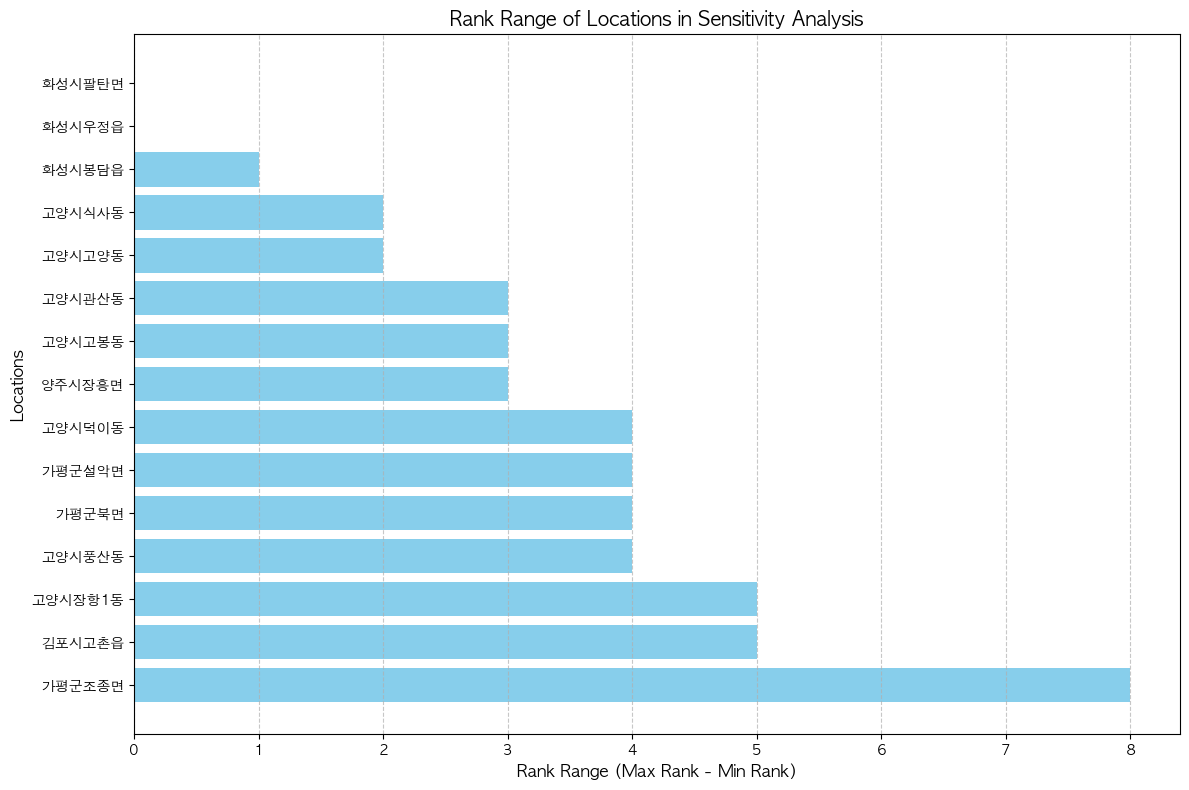

In [75]:
import matplotlib.pyplot as plt

# 데이터 정렬 (변동 범위 순으로 정렬)
rank_changes_df_sorted = rank_changes_df.sort_values("Rank Range", ascending=False)

# 시각화
plt.figure(figsize=(12, 8))
plt.barh(rank_changes_df_sorted["Location"], rank_changes_df_sorted["Rank Range"], color="skyblue")

# 그래프 꾸미기
plt.xlabel("Rank Range (Max Rank - Min Rank)", fontsize=12)
plt.ylabel("Locations", fontsize=12)
plt.title("Rank Range of Locations in Sensitivity Analysis", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# 그래프 출력
plt.tight_layout()
plt.show()

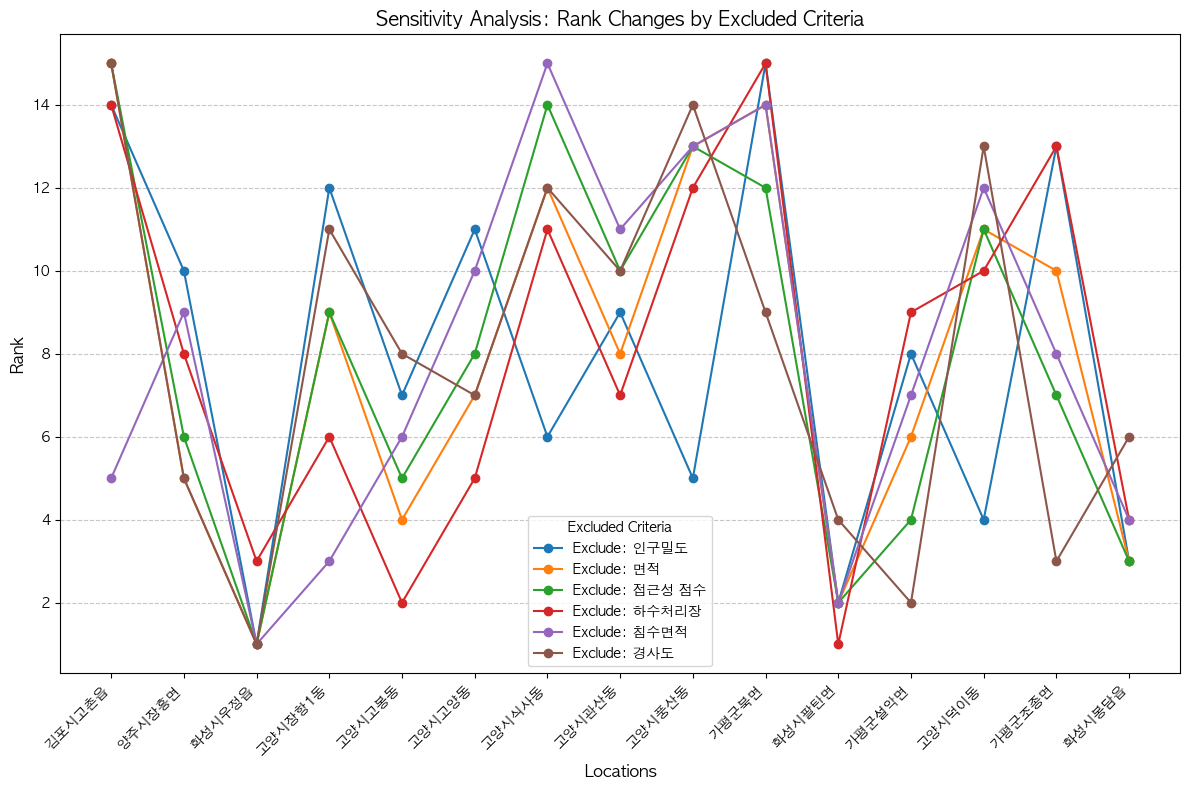

In [76]:
import matplotlib.pyplot as plt
import numpy as np

# 민감도 분석 결과 데이터
sensitivity_results = [
    {'Excluded Criteria': '인구밀도',
     'Rank Changes': np.array([14., 10.,  1., 12.,  7., 11.,  6.,  9.,  5., 15.,  2.,  8.,  4., 13.,  3.])},
    {'Excluded Criteria': '면적',
     'Rank Changes': np.array([15.,  5.,  1.,  9.,  4.,  7., 12.,  8., 13., 14.,  2.,  6., 11., 10.,  3.])},
    {'Excluded Criteria': '접근성 점수',
     'Rank Changes': np.array([15.,  6.,  1.,  9.,  5.,  8., 14., 10., 13., 12.,  2.,  4., 11.,  7.,  3.])},
    {'Excluded Criteria': '하수처리장',
     'Rank Changes': np.array([14.,  8.,  3.,  6.,  2.,  5., 11.,  7., 12., 15.,  1.,  9., 10., 13.,  4.])},
    {'Excluded Criteria': '침수면적',
     'Rank Changes': np.array([ 5.,  9.,  1.,  3.,  6., 10., 15., 11., 13., 14.,  2.,  7., 12.,  8.,  4.])},
    {'Excluded Criteria': '경사도',
     'Rank Changes': np.array([15.,  5.,  1., 11.,  8.,  7., 12., 10., 14.,  9.,  4.,  2., 13.,  3.,  6.])}
]

# 위치 이름
locations = ["김포시고촌읍", "양주시장흥면", "화성시우정읍", "고양시장항1동", "고양시고봉동",
             "고양시고양동", "고양시식사동", "고양시관산동", "고양시풍산동", "가평군북면",
             "화성시팔탄면", "가평군설악면", "고양시덕이동", "가평군조종면", "화성시봉담읍"]

# 시각화
plt.figure(figsize=(12, 8))

for result in sensitivity_results:
    excluded_criteria = result['Excluded Criteria']
    rank_changes = result['Rank Changes']

    plt.plot(locations, rank_changes, marker='o', label=f"Exclude: {excluded_criteria}")

plt.xlabel('Locations', fontsize=12)
plt.ylabel('Rank', fontsize=12)
plt.title('Sensitivity Analysis: Rank Changes by Excluded Criteria', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Excluded Criteria", fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()